Steps For Cann Edge detection


1.   Gaussian blurring
2.   Intensity gradient calculation
3.   Non-maximum suppression
4.   Double thresholding
5.   Edge tracking by hysteresis
6.   Edge thinning



In [41]:
#Libraries Needed
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from torch import nn
from torchvision.transforms import ToTensor

In [42]:
#Step1 Gassian Blurring
def Gaussian_Kernel(k=3, mu=0, sigma=1, normalize=True):
  gaussian_1d = np.linspace(-1, 1, k)

  x, y = np.meshgrid(gaussian_1d, gaussian_1d)
  distance = (x ** 2 + y ** 2) ** 0.5
  gaussian_2d = np.exp(-(distance-mu) ** 2 / (2 * sigma ** 2))
  gaussian_2d = gaussian_2d/(2 * np.pi * sigma ** 2)

  if normalize:
    gaussian_2d = gaussian_2d / np.sum(gaussian_2d)

  return gaussian_2d

The function Gaussian_Kernel takes four parameters:

1) k: Kernel size (default: 3) <br>
2) mu: Mean value of the Gaussian distribution (default: 0)<br>
3) sigma: Standard deviation of the Gaussian distribution (default: 1)<br>
4) normalize: Boolean flag to indicate whether to normalize the kernel (default: True)<br>

A) The line gaussian_1d = np.linspace(-1, 1, k) generates a 1D array of equally spaced values between -1 and 1 with a total of k values. This represents the spatial domain of the Gaussian kernel.
<br>
B) The np.meshgrid(gaussian_1d, gaussian_1d) function creates a 2D grid of coordinate values by combining the 1D array with itself. It generates two 2D arrays x and y, representing the x and y coordinates of each pixel in the grid.
<br>
C) The line distance = (x ** 2 + y ** 2) ** 0.5 calculates the Euclidean distance from the origin (0, 0) to each pixel in the grid. This distance represents the radial distance from the center of the kernel.
<br>
D) The line gaussian_2d = np.exp(-(distance - mu) ** 2 / (2 * sigma ** 2)) calculates the values of the 2D Gaussian distribution based on the distance from the center. It uses the formula of the Gaussian distribution:
<br>
E) The line gaussian_2d = gaussian_2d / (2 * np.pi * sigma ** 2) scales the values of the Gaussian distribution by dividing them by the constant factor (2 * pi * sigma^2). This step ensures that the sum of the values in the kernel is equal to 1.
<br>
F) If the normalize flag is set to True, the line `gaussian_2d = gaussian_2d /
<br>
G) The output of passing an image through the Gaussian_Kernel function will be a blurred or smoothed version of the original image.

In [43]:
#Step2 Using Sobel Edge detector to calculate gradients

def Sobel_Kernel(k=3):
  range = np.linspace(-(k // 2), k // 2, k)

  x, y = np.meshgrid(range, range)
  sobel_2d_num = x
  sobel_2d_den = (x ** 2 + y ** 2)
  sobel_2d_den[:, k // 2] = 1
  sobel_2d = sobel_2d_num / sobel_2d_den

  return sobel_2d

A) The function Sobel_Kernel takes one parameter k, which specifies the size of the Sobel kernel (default: 3).

B) The line range = np.linspace(-(k // 2), k // 2, k) generates a 1D array of equally spaced values ranging from -(k/2) to k/2, with a total of k values. This array represents the spatial domain of the Sobel kernel.

C) The np.meshgrid(range, range) function creates a 2D grid of coordinate values by combining the 1D array with itself. It generates two 2D arrays x and y, representing the x and y coordinates of each pixel in the grid.

D) The line sobel_2d_num = x stores the x coordinate values in the sobel_2d_num variable. These values represent the numerator of the Sobel kernel.

E) The line sobel_2d_den = (x ** 2 + y ** 2) calculates the sum of squares of x and y coordinate values, representing the denominator of the Sobel kernel.

F) The line sobel_2d_den[:, k // 2] = 1 assigns a value of 1 to the middle column of the denominator array. This step is necessary to avoid division by zero.

G) The line sobel_2d = sobel_2d_num / sobel_2d_den performs element-wise division of sobel_2d_num by sobel_2d_den, generating the final Sobel kernel.

H) The output of passing an image through this function is the Sobel kernel, which is a 2D matrix representing the weights assigned to neighboring pixels in the x and y directions. This kernel is used to perform convolution with the image to calculate the gradients, which indicate the rate of intensity change in the image.

In [44]:
#Performing Non Max Suppression
def NonMax_Supression(start=0, end=360, step=45):
  k_thin = 3
  k_increased = k_thin + 2

  thin_kernel_0 = np.zeros((k_increased, k_increased))
  thin_kernel_0[k_increased // 2, k_increased // 2] = 1
  thin_kernel_0[k_increased // 2, k_increased // 2 + 1:] = -1

  thin_kernels = []
  for angle in range(start, end, step):
    h, w = thin_kernel_0.shape
    center = (w // 2, h // 2)

    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
    kernel_angle_increased = cv2.warpAffine(thin_kernel_0, rotation_matrix, (w, h), cv2.INTER_NEAREST)


    kernel_angle = kernel_angle_increased[1:-1, 1:-1]
    is_diag = (abs(kernel_angle) == 1)
    kernel_angle = kernel_angle * is_diag
    thin_kernels.append(kernel_angle)

  return thin_kernels

The function NonMax_Suppression takes three parameters: start, end, and step, which specify the range of angles for generating thinning kernels (default: start=0, end=360, step=45).

The variable k_thin represents the size of the initial thinning kernel (default: 3).

The variable k_increased calculates the size of the kernel with padding, which is k_thin + 2.

The line thin_kernel_0 = np.zeros((k_increased, k_increased)) creates a square matrix of zeros with dimensions k_increased x k_increased.

The line thin_kernel_0[k_increased // 2, k_increased // 2] = 1 sets the center pixel of thin_kernel_0 to 1.

The line thin_kernel_0[k_increased // 2, k_increased // 2 + 1:] = -1 assigns the values -1 to the pixels in the row of thin_kernel_0 right of the center, creating a thinning effect.

The thin_kernels list is initialized to store the thinning kernels for different angles.

The for loop iterates over the specified range of angles.

Inside the loop, the shape of thin_kernel_0 is extracted into h and w.

The center of rotation is calculated as (w // 2, h // 2).

The cv2.getRotationMatrix2D function generates a rotation matrix for the given angle and center.

The cv2.warpAffine function applies the rotation matrix to thin_kernel_0, resulting in kernel_angle_increased with increased dimensions due to padding.

The line kernel_angle = kernel_angle_increased[1:-1, 1:-1] extracts the inner part of kernel_angle_increased, removing the padding and keeping the desired kernel size.

The line `is_diag = (abs(kernel_angle) == 1)` creates a binary mask where `is_diag` is `True` for values in `kernel_angle` that are equal to 1.

The line `kernel_angle = kernel_angle * is_diag` zeros out the non-diagonal elements of `kernel_angle`, leaving only the diagonal elements (1s).

The `kernel_angle` is appended to the `thin_kernels` list.

Once all angles have been processed, the list of thinning kernels, `thin_kernels`, is returned.

The output of passing an image through this function would be a list of thinning kernels for different angles. These kernels can be used to perform non-maximum suppression on the image gradients obtained from the Sobel operator, ensuring that only the local maximum values along the edges are preserved while suppressing non-maximum values.

The thinning kernels help refine the edge detection results by reducing the width of detected edges to a single pixel width, enhancing their clarity and accuracy.

In [45]:
# Lets define our canny edge detection class to find the the output
class CannyFilter(nn.Module):
    def __init__(self,
                 k_gaussian=3,
                 mu=0,
                 sigma=1,
                 k_sobel=3,
                 use_cuda=False):
        super(CannyFilter, self).__init__()
        # device
        self.device = 'cuda' if use_cuda else 'cpu'

        # gaussian

        gaussian_2D = Gaussian_Kernel(k_gaussian, mu, sigma)
        self.gaussian_filter = nn.Conv2d(in_channels=1,
                                         out_channels=1,
                                         kernel_size=k_gaussian,
                                         padding=k_gaussian // 2,
                                         bias=False)
        self.gaussian_filter.weight[:] = torch.from_numpy(gaussian_2D)

        # sobel

        sobel_2D = Sobel_Kernel(k_sobel)
        self.sobel_filter_x = nn.Conv2d(in_channels=1,
                                        out_channels=1,
                                        kernel_size=k_sobel,
                                        padding=k_sobel // 2,
                                        bias=False)
        self.sobel_filter_x.weight[:] = torch.from_numpy(sobel_2D)


        self.sobel_filter_y = nn.Conv2d(in_channels=1,
                                        out_channels=1,
                                        kernel_size=k_sobel,
                                        padding=k_sobel // 2,
                                        bias=False)
        self.sobel_filter_y.weight[:] = torch.from_numpy(sobel_2D.T)


        # thin

        thin_kernels = NonMax_Supression()
        directional_kernels = np.stack(thin_kernels)

        self.directional_filter = nn.Conv2d(in_channels=1,
                                            out_channels=8,
                                            kernel_size=thin_kernels[0].shape,
                                            padding=thin_kernels[0].shape[-1] // 2,
                                            bias=False)
        self.directional_filter.weight[:, 0] = torch.from_numpy(directional_kernels)

        # hysteresis

        hysteresis = np.ones((3, 3)) + 0.25
        self.hysteresis = nn.Conv2d(in_channels=1,
                                    out_channels=1,
                                    kernel_size=3,
                                    padding=1,
                                    bias=False)
        self.hysteresis.weight[:] = torch.from_numpy(hysteresis)


    def forward(self, img, low_threshold=None, high_threshold=None, hysteresis=False):
        # set the setps tensors
        B, C, H, W = img.shape
        blurred = torch.zeros((B, C, H, W)).to(self.device)
        grad_x = torch.zeros((B, 1, H, W)).to(self.device)
        grad_y = torch.zeros((B, 1, H, W)).to(self.device)
        grad_magnitude = torch.zeros((B, 1, H, W)).to(self.device)
        grad_orientation = torch.zeros((B, 1, H, W)).to(self.device)

        # gaussian

        for c in range(C):
            blurred[:, c:c+1] = self.gaussian_filter(img[:, c:c+1])

            grad_x = grad_x + self.sobel_filter_x(blurred[:, c:c+1])
            grad_y = grad_y + self.sobel_filter_y(blurred[:, c:c+1])

        # thick edges

        grad_x, grad_y = grad_x / C, grad_y / C
        grad_magnitude = (grad_x ** 2 + grad_y ** 2) ** 0.5
        grad_orientation = torch.atan(grad_y / grad_x)
        grad_orientation = grad_orientation * (360 / np.pi) + 180 # convert to degree
        grad_orientation = torch.round(grad_orientation / 45) * 45  # keep a split by 45

        # thin edges

        directional = self.directional_filter(grad_magnitude)
        # get indices of positive and negative directions
        positive_idx = (grad_orientation / 45) % 8
        negative_idx = ((grad_orientation / 45) + 4) % 8
        thin_edges = grad_magnitude.clone()
        # non maximum suppression direction by direction
        for pos_i in range(4):
            neg_i = pos_i + 4
            # get the oriented grad for the angle
            is_oriented_i = (positive_idx == pos_i) * 1
            is_oriented_i = is_oriented_i + (positive_idx == neg_i) * 1
            pos_directional = directional[:, pos_i]
            neg_directional = directional[:, neg_i]
            selected_direction = torch.stack([pos_directional, neg_directional])

            # get the local maximum pixels for the angle
            is_max = selected_direction.min(dim=0)[0] > 0.0
            is_max = torch.unsqueeze(is_max, dim=1)

            # apply non maximum suppression
            to_remove = (is_max == 0) * 1 * (is_oriented_i) > 0
            thin_edges[to_remove] = 0.0

        # thresholds

        if low_threshold is not None:
            low = thin_edges > low_threshold

            if high_threshold is not None:
                high = thin_edges > high_threshold
                # get black/gray/white only
                thin_edges = low * 0.5 + high * 0.5

                if hysteresis:
                    # get weaks and check if they are high or not
                    weak = (thin_edges == 0.5) * 1
                    weak_is_high = (self.hysteresis(thin_edges) > 1) * weak
                    thin_edges = high * 1 + weak_is_high * 1
            else:
                thin_edges = low * 1

        return blurred, grad_x, grad_y, grad_magnitude, grad_orientation, thin_edges


blurred: torch.Size([1, 1, 528, 796])
grad_x: torch.Size([1, 1, 528, 796])
grad_y: torch.Size([1, 1, 528, 796])
grad_magnitude: torch.Size([1, 1, 528, 796])
grad_orientation: torch.Size([1, 1, 528, 796])
thin_edges: torch.Size([1, 1, 528, 796])


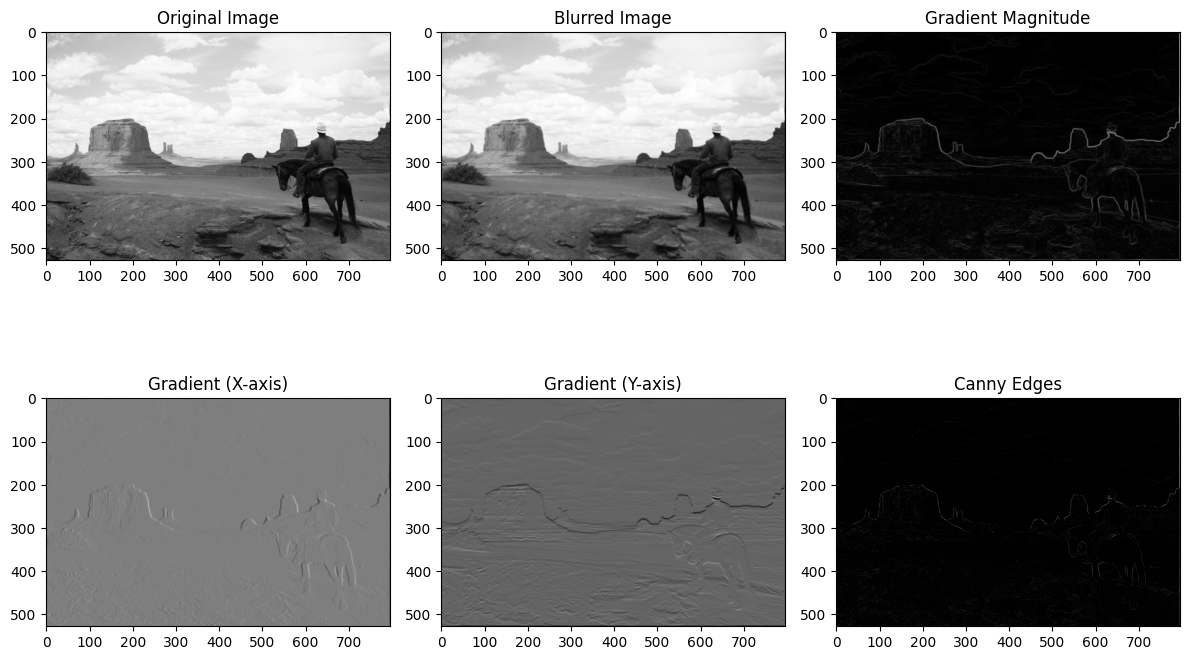

In [46]:
#Now lets make our driver function
from torch.autograd.grad_mode import no_grad
image_path = '/content/horse.png'
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Convert the grayscale image to a tensor
tensor_image = ToTensor()(gray_image).unsqueeze(0)

with torch.no_grad():
  canny_filter = CannyFilter()
  blurred, grad_x, grad_y, grad_magnitude, grad_orientation, thin_edges = canny_filter(tensor_image)


print(f"blurred: {blurred.shape}")
print(f"grad_x: {grad_x.shape}")
print(f"grad_y: {grad_y.shape}")
print(f"grad_magnitude: {grad_magnitude.shape}")
print(f"grad_orientation: {grad_orientation.shape}")
print(f"thin_edges: {thin_edges.shape}")

blurred = blurred.cpu().detach().numpy()[0, 0]
grad_x = grad_x.cpu().detach().numpy()[0, 0]
grad_y = grad_y.cpu().detach().numpy()[0, 0]
grad_magnitude = grad_magnitude.cpu().detach().numpy()[0, 0]
grad_orientation = grad_orientation.cpu().detach().numpy()[0, 0]
thin_edges = thin_edges.cpu().detach().numpy()[0, 0]

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs[0, 0].imshow(gray_image, cmap='gray')
axs[0, 0].set_title('Original Image')
axs[0, 1].imshow(blurred, cmap='gray')
axs[0, 1].set_title('Blurred Image')
axs[0, 2].imshow(grad_magnitude, cmap='gray')
axs[0, 2].set_title('Gradient Magnitude')
axs[1, 0].imshow(grad_x, cmap='gray')
axs[1, 0].set_title('Gradient (X-axis)')
axs[1, 1].imshow(grad_y, cmap='gray')
axs[1, 1].set_title('Gradient (Y-axis)')
axs[1, 2].imshow(thin_edges, cmap='gray')
axs[1, 2].set_title('Canny Edges')
plt.tight_layout()
plt.show()




>Thus we have successfully implemented the Canny Edge Detection
